In [1]:
# Combine Time-Dependence and SimpleDiff

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sympy import *
import matplotlib.pyplot as plt
init_printing(use_latex=true)
filename = "TestData.xlsx"

In [2]:
# Establish symbols
n, T, i, t, lda, eps = symbols('n T i t \lambda \epsilon')       # n wells & T timepoints

In [3]:
# Establish number of wells
n = pd.read_excel(filename, sheet_name='n').iloc[0,0]
n

5

In [4]:
# Establish number of timepoints
T = pd.read_excel(filename, sheet_name='T').iloc[0,0]
T

41

In [5]:
# Establish binary matrix for wells being on or off
z = MatrixSymbol('z', n, T)      # Row 0 = well 0   , Column 3 = Timepoint 3
#pprint(z.as_explicit())
zReal = Matrix(pd.read_excel(filename, sheet_name="OnOff").to_numpy().T)
zReal

⎡0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1 
⎢                                                                             
⎣0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1⎤
                                            ⎥
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1⎥
                                            ⎥
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1⎥
                                            ⎥
 1  1  1  1 

In [6]:
# Establish binary matrix for wells being measured or not
d = MatrixSymbol('d', n, T)      # Row 0 = well 0   , Column 3 = Timepoint 3
#pprint(d.as_explicit())
dReal = Matrix(pd.read_excel(filename, sheet_name="Measured").to_numpy().T)
dTotal = sum(dReal)
dReal

⎡0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
⎢                                                                             
⎣0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0⎤
                                            ⎥
 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0⎥
                                            ⎥
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0⎥
                                            ⎥
 0  0  0  0 

In [7]:
# Establish matrix of actual mass flows
m = MatrixSymbol('m', n, T)  
#pprint(m.as_explicit())
mReal = Matrix(pd.read_excel(filename, sheet_name="MassFlows").to_numpy().T)
mReal

⎡0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  70.3  143.1  140.6  138
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  65.5  133.1  130.6  128
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0      0    36.0   61.
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0      0      0      0
⎢                                                                             
⎣0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0      0      0      0

.4  136.4  134.7  133.5  132.7  132.0  130.8  127.3  123.8  122.4  121.5  120.
                                                                              
.4  126.4  124.7  123.5  122.7  122.0  120.8  117.3  113.8  112.4  111.5  110.
                                                   

In [8]:
# Establish matrix / vector of total mass flow
M = MatrixSymbol('M', 1, T)
#pprint(M.as_explicit())
MReal = Matrix(pd.read_excel(filename, sheet_name="TotalMassFlow").to_numpy().T)
MReal

[0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0.02  135.81  276.19  307.
2  328.59  327.84  359.56  365.59  363.27  361.32  358.23  385.31  482.47  481
.56  478.19  475.64  473.44  471.56  469.85  468.27  466.42  464.29  461.96  4
60.39]

In [9]:
# Establish solution vectors of initial mass flows and gradients per well 
wc = MatrixSymbol('wc', n, 1)
pprint(wc.as_explicit())
wg = MatrixSymbol('wg', n, 1)
pprint(wg.as_explicit())

# At any timepoint, w = wc + t*wg

⎡wc₀₀⎤
⎢    ⎥
⎢wc₁₀⎥
⎢    ⎥
⎢wc₂₀⎥
⎢    ⎥
⎢wc₃₀⎥
⎢    ⎥
⎣wc₄₀⎦
⎡wg₀₀⎤
⎢    ⎥
⎢wg₁₀⎥
⎢    ⎥
⎢wg₂₀⎥
⎢    ⎥
⎢wg₃₀⎥
⎢    ⎥
⎣wg₄₀⎦


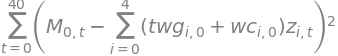

In [10]:
S1 = Sum((M[0,t] - Sum(z[i, t]*(wc[i,0]+t*wg[i,0]), (i, 0, n-1)))**2 , (t, 0, T-1))
S1

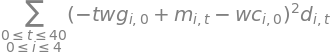

In [11]:
S2 = Sum(Sum(d[i,t]*((m[i,t]-(wc[i,0]+t*wg[i,0])))**2 , (t, 0, T-1)), (i, 0, n-1))
S2

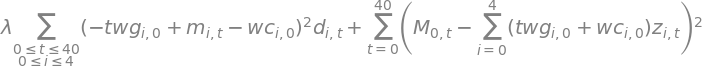

In [12]:
I = S1 + lda*S2
I

In [13]:
Inac = I.subs({M: MReal, z: zReal, d: dReal, m: mReal})
Inac

                                                                              
                                                                              
                                                                              
                                                                              
           4       40                                                         
        _______ _______                                                       
        ╲       ╲                                                             
         ╲       ╲                                                            
          ╲       ╲     ⎛                ⎛⎡0  0  0  0  0  0  0  0  0  0  0  0 
           ╲       ╲    ⎜                ⎜⎢                                   
            ╲       ╲   ⎜                ⎜⎢0  0  0  0  0  0  0  0  0  0  0  0 
             ╲       ╲  ⎜                ⎜⎢                                   
\lambda⋅     ╱       ╱  ⎜-t⋅(wg)[i, 0] + ⎜⎢0  0  0  

In [14]:
optLda = T*n**2/dTotal
Inaccuracy = Inac.subs(lda, optLda)
optLda

In [15]:
Inaccuracy.diff(wc[0,0]).doit()

In [16]:
DiffA = np.zeros([2*n,2*n])
Diffb = np.zeros(2*n)
# Fill in matrix with values for Aw=b   (w = [wc; wg])
for i in range(n):
    Diffb[i] = -1*Poly(Inaccuracy.diff(wc[i,0]).doit()).coeffs()[-1]
    Diffb[n+i] = -1*Poly(Inaccuracy.diff(wg[i,0]).doit()).coeffs()[-1]
    for j in range(n):
        DiffA[i,j] = Inaccuracy.diff(wc[i,0]).doit().coeff(wc[j,0])
        DiffA[i+n,j] = Inaccuracy.diff(wg[i,0]).doit().coeff(wc[j,0])
        DiffA[i,j+n] = Inaccuracy.diff(wc[i,0]).doit().coeff(wg[j,0])
        DiffA[i+n,j+n] = Inaccuracy.diff(wg[i,0]).doit().coeff(wg[j,0])
# Then solve for w
DiffMatrixA = Matrix(DiffA)
DiffMatrixb = Matrix(Diffb)
DiffMatrixA

⎡ 456.0    46.0     42.0     38.0     26.0    10354.0    1334.0    1260.0    1
⎢                                                                             
⎢ 46.0     456.0    42.0     38.0     26.0     1334.0   12404.0    1260.0    1
⎢                                                                             
⎢ 42.0     42.0     452.0    38.0     26.0     1260.0    1260.0   11510.0    1
⎢                                                                             
⎢ 38.0     38.0     38.0     448.0    26.0     1178.0    1178.0    1178.0   14
⎢                                                                             
⎢ 26.0     26.0     26.0     26.0     436.0    884.0     884.0     884.0     8
⎢                                                                             
⎢10354.0  1334.0   1260.0   1178.0    884.0   239150.0  40710.0   39340.0   37
⎢                                                                             
⎢1334.0   12404.0  1260.0   1178.0    884.0   40710.

In [17]:
DiffMatrixb

⎡ 74369.9  ⎤
⎢          ⎥
⎢ 67973.9  ⎥
⎢          ⎥
⎢ 41893.9  ⎥
⎢          ⎥
⎢ 34923.32 ⎥
⎢          ⎥
⎢ 70216.7  ⎥
⎢          ⎥
⎢1787736.98⎥
⎢          ⎥
⎢1894664.98⎥
⎢          ⎥
⎢1148824.6 ⎥
⎢          ⎥
⎢1110271.82⎥
⎢          ⎥
⎣2097128.22⎦

In [18]:
results = DiffMatrixA.inv()*DiffMatrixb
results

⎡158.719238729624 ⎤
⎢                 ⎥
⎢-69.5274997960951⎥
⎢                 ⎥
⎢ 328.15352481608 ⎥
⎢                 ⎥
⎢55.5489442364196 ⎥
⎢                 ⎥
⎢-4.43141612550244⎥
⎢                 ⎥
⎢-1.01451085134249⎥
⎢                 ⎥
⎢7.04916665911333 ⎥
⎢                 ⎥
⎢-10.7601574330806⎥
⎢                 ⎥
⎢-0.32106903427848⎥
⎢                 ⎥
⎣5.03481419180389 ⎦

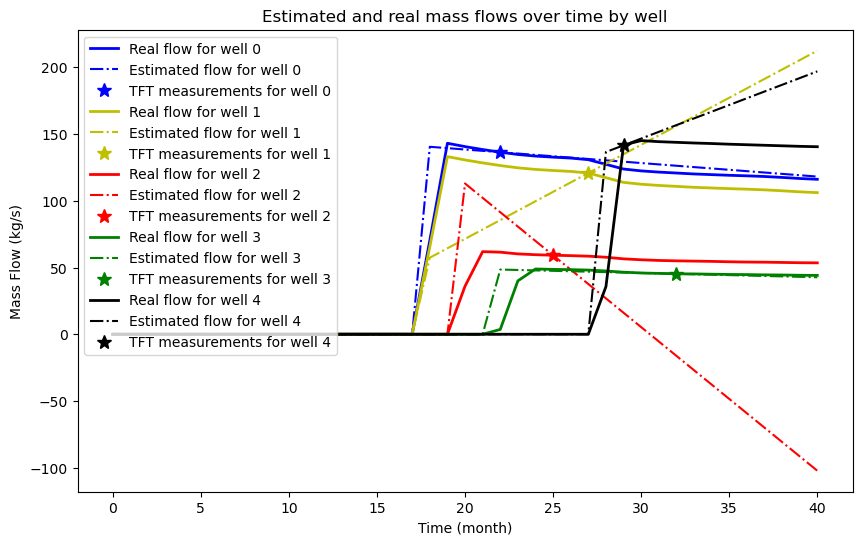

In [19]:
# Plot results from all wells
plt.figure(figsize=(10,6))
colours=['b', 'y', 'r', 'g', 'k']
for i in range(n):
    plt.plot(range(T),mReal[i,:][:], colours[i]+'-', lw=2, label="Real flow for well "+str(i))
    # Plot Time-Dependently
    toplot = []
    for t in range(T):
        resplot = (results[i]+t*results[i+n])
        toplot.append(resplot*zReal[i,t])
    plt.plot(range(T),toplot, colours[i]+'-.', lw=1.5, label="Estimated flow for well "+str(i))
    # Plot TFT points
    monthplot = []
    tftplot = []
    for month,element in enumerate(dReal[i,:]):
        if element==1:
            monthplot.append(month)
            tftplot.append(mReal[i,month])
    plt.plot(monthplot, tftplot, colours[i]+'*', markersize=10, label="TFT measurements for well "+str(i))
            
plt.title("Estimated and real mass flows over time by well")
plt.xlabel("Time (month)")
plt.ylabel("Mass Flow (kg/s)")
plt.legend(loc=2)


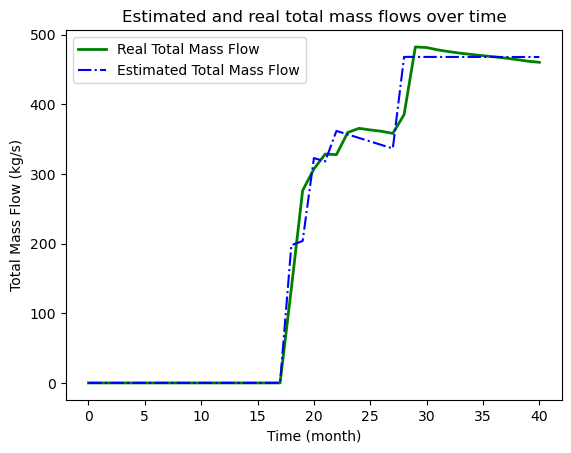

In [20]:
# Plot total flow vs found total flow
totalFlowFound = np.zeros((T,1))
times = range(T)
for t in range(T):
    tff = [(results[i]+t*results[i+n])*zReal[i,t] for i in range(n)]
    #print(t, tff)
    totalFlowFound[t] = sum(tff)

plt.plot(list(Matrix(times).T), list(MReal), 'g-', lw=2, label="Real Total Mass Flow")
plt.plot(times,totalFlowFound, 'b-.', lw=1.5, label="Estimated Total Mass Flow")

plt.title("Estimated and real total mass flows over time")
plt.xlabel("Time (month)")
plt.ylabel("Total Mass Flow (kg/s)")
plt.legend()

Results are wrong, but completely feasible, too much freedom with the linearity!

Constrain non-negativity?